In [1]:
import numpy as np
import pandas as pd
import json
import math
import random
import scipy

from geopy.distance import geodesic
from shapely.geometry import Point, LineString

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

torch.manual_seed(0)
np.random.seed(0)

# Prediction Model - Stacked LSTM

In [35]:
df = pd.read_csv('train.csv')
df['LENGTH'] = df['POLYLINE'].apply(lambda x: len(json.loads(x)))
df = df[df['LENGTH'] > 8]
sample = df[df.MISSING_DATA==False].sample(n=10000, random_state=42).copy(deep=True)
# sample  = pd.read_csv("sample.csv", index_col=0)

In [36]:
coordinates = [item for trajectory in list(sample['POLYLINE'].apply(lambda x: json.loads(x))) for item in trajectory]
coordinates = np.array(coordinates)
scaler = MinMaxScaler()
scaler.fit(coordinates)

MinMaxScaler()

In [37]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers=2, dropout=0.2):
        super(Model, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.in2lstm1 = nn.Linear(input_size, hidden_size)
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=False, batch_first=True, dropout=dropout)
        
        self.in2lstm2 = nn.Linear(input_size, hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=False, batch_first=True, dropout=dropout)
        
        self.fc0 = nn.Linear(hidden_size, hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, int(hidden_size/2))
        self.fc2 = nn.Linear(input_size, int(hidden_size/2))
        self.fc3 = nn.Linear(int(hidden_size/2), output_size)
        
        #self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        lstm_out1, _ = self.lstm1(self.in2lstm1(x))
        lstm_out2, _ = self.lstm2(self.in2lstm2(x))
        out1 = self.tanh(self.fc0(lstm_out1 + lstm_out2))
        #out = self.tanh(self.fc0(lstm_out1))
        out1 = self.tanh(self.fc1(out1))
        out2 = self.tanh(self.fc2(x))
        output = self.fc3(out1 + out2)[:, -1]
        return output

In [38]:
INPUT_SIZE=2
OUTPUT_SIZE=2
HIDDEN_SIZE=32
NUM_LAYERS = 2

model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.load_state_dict(torch.load('Stacked_LSTM_Traj_Prediction.pt', map_location=torch.device('cpu')))
model.eval()

Model(
  (in2lstm1): Linear(in_features=2, out_features=32, bias=True)
  (lstm1): LSTM(32, 32, num_layers=2, batch_first=True, dropout=0.2)
  (in2lstm2): Linear(in_features=2, out_features=32, bias=True)
  (lstm2): LSTM(32, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc0): Linear(in_features=32, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=2, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
  (tanh): Tanh()
)

0.14478551958705413 km
0.14014236416337392 km
0.04357752159675988 km
0.07283131960690166 km
0.17112687827666584 km
0.16860653556297023 km
0.21507538675746382 km
0.24291089217403253 km
0.1208639335805232 km
0.17439486780346009 km
0.25692065451035645 km
0.26782377744009483 km
0.1541609743525159 km
0.18943542081446552 km
0.04106874881868186 km
0.030217466446751107 km
0.029813651013176408 km


<AxesSubplot:>

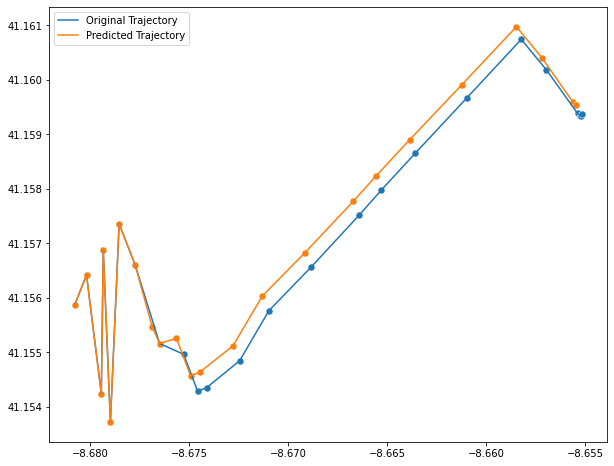

In [39]:
trajectory = json.loads(list(df['POLYLINE'])[258])
n = len(trajectory)
trajectory = np.array(trajectory)
predictions = np.empty_like(trajectory)
predictions[:8, :] = trajectory[:8, :]
for i in range(8, n):
    X = torch.tensor(scaler.transform(trajectory[i-8:i, :])).float()
    pred = model(X.unsqueeze(0)).detach().numpy()
    pred = scaler.inverse_transform(pred)
    # pre_1, pre_2 = X[-2:]
    # pred = pre_2 + (pre_2 - pre_1)
    # pred = scaler.inverse_transform(pred.unsqueeze(0))
    predictions[i, :] = pred
    print(geodesic(predictions[i, ::-1], trajectory[i, ::-1]))

plt.figure(figsize=(10, 8))
sns.lineplot(x=trajectory[:, 0], y=trajectory[:, 1],  label='Original Trajectory')
sns.scatterplot(x=trajectory[:, 0], y=trajectory[:, 1], s = 50, legend=False)
sns.lineplot(x=predictions[:, 0], y=predictions[:, 1], markers=True, label='Predicted Trajectory')
sns.scatterplot(x=predictions[:, 0], y=predictions[:, 1], s = 50, legend=False)

In [40]:
dist = 0
for i in range(1, len(trajectory)):
    pre_point = trajectory[i-1][::-1]
    cur_point = trajectory[i][::-1]
    dist += geodesic(pre_point, cur_point).km

In [41]:
dist

2.890197270793191

# Privacy Mechanism

In [42]:
eps_theta = 2e3
eps_N = 5e2

def random_laplace_noise(eps):
    '''
    Given epsilon > 0, this function returns relative 
    coordinates of the generated laplace noise, which 
    follows a planer laplace distribution centered at
    x with epsilon as the scale.
    '''
    # generate polar coordinates
    theta = np.random.uniform(0, 2*math.pi) # this shall be the angular coordinate
    
    p = random.random() # draw a random sample from unif(0, 1)
    r = -1/eps * (scipy.special.lambertw((p-1)/math.e, k=-1, tol=1e-8).real + 1) #this shall be the radial coordinate
    
    # convert polar coordinates to cartesian coordinates
    x, y = r * math.cos(theta), r * math.sin(theta)
    
    return x, y

def PM(trajectory):
    trajectory = np.array(trajectory)
    r = []
    points = []
    for x in trajectory:
        if len(points) <= 8:
            b = 1
            z = x + random_laplace_noise(eps_theta)
        else:
            z, b = Step(points[-8:], x)
        r.append((z, b))
        points.append(z)
    df = pd.DataFrame({'Lon': [p[0] for p in points], 'Lat': [p[1] for p in points], 'Bool': [item[1] for item in r]})
    return r, df

def Step(points, x):
    points = scaler.transform(np.array(points))
    points = torch.tensor(points).float()
    points = points.unsqueeze(0)
    next_point = model(points).detach().numpy()
    next_point = scaler.inverse_transform(next_point).squeeze(0)
    print(geodesic(next_point[::-1], x[::-1]))
    if geodesic(next_point[::-1], x[::-1]) < 0.2 + np.random.laplace(loc=0, scale=1/eps_N, size=None):
        b = 0
        z = next_point
    else:
        b = 1
        z = x + random_laplace_noise(eps_theta)
    return z, b       

# Demo

In [44]:
trajectory = np.array(json.loads(list(df['POLYLINE'])[0]))
encoded_trajectory, data = PM(trajectory)
data['Color'] = data['Bool'].apply(lambda x: 'red' if x==1 else 'green')

0.19254500179577289 km
0.47601777544550694 km
0.06875240329885442 km
0.07332387741834383 km
0.1531433082974996 km
0.17416835697619976 km
0.1831520271092083 km
0.156357178952698 km
0.24615772019689688 km
0.29912301315399153 km
0.1438695721244277 km
0.15362472674386626 km
0.16610368382975477 km
0.17733737773462296 km


<AxesSubplot:xlabel='Lon', ylabel='Lat'>

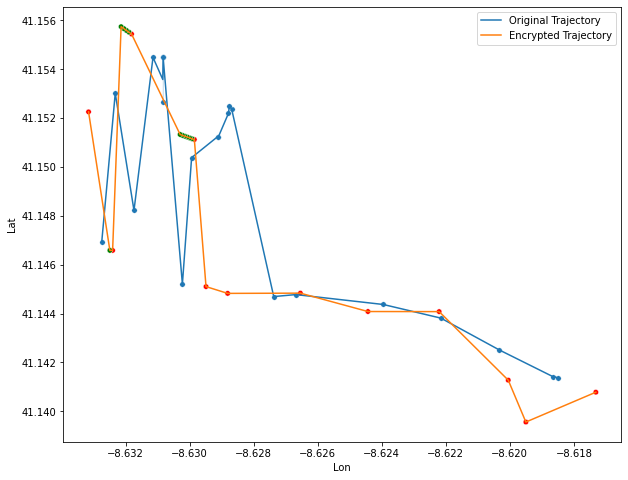

In [45]:
plt.figure(figsize=(10, 8))
sns.lineplot(x=trajectory[:, 0], y=trajectory[:, 1], label='Original Trajectory')
sns.scatterplot(x=trajectory[:, 0], y=trajectory[:, 1], s = 30, legend=False)
sns.lineplot(data=data, x='Lon', y='Lat', label='Encrypted Trajectory')
sns.scatterplot(data=data, x='Lon', y='Lat', c=data['Color'], s = 30, legend=False)